In [7]:
!pip3 install openai==0.28.0
!pip install pygame
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2/155.2 kB 8.0 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 45.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 67.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.3 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


In [2]:
import gym
from gym import spaces
import pygame
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import json
import random

In [3]:
info = dict()
with open("699_recipe_5.json", "r") as f:
    d = json.load(f)
    for i in d["dataset"]:
      e = i["key"]
      if e not in info.keys():
          v = i["value"]
          n_v = set()
          for value in v:
              n_v.add(tuple(value))
          info[e] = n_v
      else:
          value = info[e]
          v = i["value"]
          n_v = set()
          for elements in v:
              n_v.add(tuple(elements))
          n_v = value.union(n_v)
          info[e] = n_v

#info key is command, value is set with multiple solutions and each solution type is tuple
print(info)






{'Serve Apple Salad to Person in Red': {('Go to Red Apple', 'Take Red Apple', 'Go to Green Apple', 'Take Green Apple', 'Go to Knife', 'Prepare Red Apple', 'Prepare Green Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red'), ('Go to Green Apple', 'Take Green Apple', 'Go to Red Apple', 'Take Red Apple', 'Go to Knife', 'Prepare Green Apple', 'Prepare Red Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red')}, 'Serve Cheese Platter to Person in White': {('Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare Yellow Cheese', 'Prepare White Cheese', 'Go to Plate', 'Place White and Yellow Cheese on Plate', 'Serve plate to Person in White'), ('Go to White Cheese', 'Take White Cheese', 'Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to Knife', 'Prepare White Cheese', 'Prepare Yellow Cheese', 'Go to Plate', 'Place White

In [7]:
from abc import update_abstractmethods
env_items={
  "ingredients": [
    "Red Onions",
    "Yellow Onions",
    "Bread",
    "Yellow Cheese",
    "White Cheese",
    "Red Bell Pepper",
    "Green Bell Pepper",
    "Red Apple",
    "Green Apple",
    "Yellow Egg",
    "White Egg",
    "Butter",
    "Ham",
    "Red Meat (Beef)",
    "White Meat (Turkey)",
    "Salt",
    "Herbs"
  ],
  "kitchenTools": [
    "Plate",
    "Pot",
    "Oven",
    "Knife",
    "Mixing Bowl"
  ]
}

action_list={
  "actions": [
    "Go to",
    "Use",
    "Prepare",
    "Take",
    "Drop",
    "Place on/in"
  ]
}


#reference from https://www.gymlibrary.dev/content/environment_creation/
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, the_size=30):
        self.size = the_size
        self.window_size = 1000

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None

        self.counter = 0
        self.food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

        self.tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

        self.guest_list = ["Red","White","Green","Yellow"]

        #It is a list of food that agent is taking
        self.taking_item = []

        all_obs = {"Agent": spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedApple": spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedOnions":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowOnions":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Bread":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowCheese":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteCheese":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedBellPepper":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "GreenBellPepper":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "GreenApple":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowEgg":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteEgg":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Butter":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Ham":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedMeat":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteMeat":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Salt":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Herbs":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Pot":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Oven":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Knife":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "MixingBowl":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Plate":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "GreenGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int)}
        self.observation_space = spaces.Dict(all_obs)
        self.action = spaces.Discrete(9)

        down = np.array([1,0])
        up = np.array([-1,0])
        right = np.array([0,1])
        left = np.array([0,-1])

        self._action_to_direction = {0: right,1: left,2: down,3: up}

        all_locations = [np.array([x, y]) for x in range(self.size) for y in range(self.size)]

        # Shuffle the locations
        random.shuffle(all_locations)


        # It is a map that stores all locations of food, tools, and guest
        self.map_info = [[None for _ in range(self.size)] for _ in range(self.size)]
        
        for item in self.food_list:
            location = all_locations.pop()
            x = location[0]
            y = location[1]
            setattr(self, f'_{item}_location', location)
            self.map_info[x][y] = item
            # key_name = f'_{item}_location'
            # self.all_loc[key_name] = location

        # It is a dictionary that all of tools and list of the food on tools(include plate)
        self.food_on = dict()
        for item in self.tools_list:
            location = all_locations.pop()
            setattr(self, f'_{item}_location', location)
            x = location[0]
            y = location[1]
            self.map_info[x][y] = item
            self.food_on[item] = None

        for guest in self.guest_list:
            location = all_locations.pop()
            setattr(self, f'_{guest}_location', location)
            x = location[0]
            y = location[1]
            self.map_info[x][y] = guest
            # key_name = f'_{item}_location'
            # self.all_loc[key_name] = location

        self.food_on["Plate"] = None
        p_loc = all_locations.pop()
        setattr(self, '_Plate_location', p_loc)
        x = p_loc[0]
        y = p_loc[1]
        self.map_info[x][y] = "Plate"
        # print(self.map_info)

        a_loc = all_locations.pop()
        setattr(self, '_Agent_location', a_loc)
        


    def _get_obs(self):
        return {"Agent": self._Agent_location,
                "Red Apple": self._RedApple_location,
                "Red Onions": self._RedOnions_location,
                "Yellow Onions": self._YellowOnions_location,
                "Bread": self._Bread_location,
                "Yellow Cheese": self._YellowCheese_location,
                "White Cheese": self._WhiteCheese_location,
                "Red Bell Pepper": self._RedBellPepper_location,
                "Green Bell Pepper": self._GreenBellPepper_location,
                "Green Apple": self._GreenApple_location,
                "Yellow Egg": self._YellowEgg_location,
                "White Egg": self._WhiteEgg_location,
                "Butter": self._Butter_location,
                "Ham": self._Ham_location,
                "Red Meat (Beef)": self._RedMeat_location,
                "White Meat (Turkey)": self._WhiteMeat_location,
                "Salt": self._Salt_location,
                "Herbs": self._Herbs_location,
                "Pot": self._Pot_location,
                "Oven": self._Oven_location,
                "Knife": self._Knife_location,
                "Mixing Bowl": self._MixingBowl_location,
                "Plate": self._Plate_location,
                "RedGuest": self._Red_location,
                "WhiteGuest": self._White_location,
                "GreenGuest": self._Green_location,
                "YellowGuest": self._Yellow_location
                }

    #It will return a dictionary that contains all distances between agent and food, tools, and guest. Also it will return a list of food that agent is taking
    def _get_info(self):
        redapple_dis = np.linalg.norm(self._Agent_location - self._RedApple_location, ord=1)
        redonions_dis = np.linalg.norm(self._Agent_location - self._RedOnions_location, ord=1)
        yellowonions_dis = np.linalg.norm(self._Agent_location - self._YellowOnions_location, ord=1)
        bread_dis = np.linalg.norm(self._Agent_location - self._Bread_location, ord=1)
        yellowcheese_dis = np.linalg.norm(self._Agent_location - self._YellowCheese_location, ord=1)
        whitecheese_dis = np.linalg.norm(self._Agent_location - self._WhiteCheese_location, ord=1)
        redbellpepper_dis = np.linalg.norm(self._Agent_location - self._RedBellPepper_location, ord=1)
        greenbellpepper_dis = np.linalg.norm(self._Agent_location - self._GreenBellPepper_location, ord=1)
        greenapple_dis = np.linalg.norm(self._Agent_location - self._GreenApple_location, ord=1)
        yellowegg_dis = np.linalg.norm(self._Agent_location - self._YellowEgg_location, ord=1)
        whiteegg_dis = np.linalg.norm(self._Agent_location - self._WhiteEgg_location, ord=1)
        butter_dis = np.linalg.norm(self._Agent_location - self._Butter_location, ord=1)
        ham_dis = np.linalg.norm(self._Agent_location - self._Ham_location, ord=1)
        redmeat_dis = np.linalg.norm(self._Agent_location - self._RedMeat_location, ord=1)
        whitemeat_dis = np.linalg.norm(self._Agent_location - self._WhiteMeat_location, ord=1)
        salt_dis = np.linalg.norm(self._Agent_location - self._Salt_location, ord=1)
        herbs_dis = np.linalg.norm(self._Agent_location - self._Herbs_location, ord=1)
        pot_dis = np.linalg.norm(self._Agent_location - self._Pot_location, ord=1)
        oven_dis = np.linalg.norm(self._Agent_location - self._Oven_location, ord=1)
        knife_dis = np.linalg.norm(self._Agent_location - self._Knife_location, ord=1)
        mixingbowl_dis = np.linalg.norm(self._Agent_location - self._MixingBowl_location, ord=1)
        plate_dis = np.linalg.norm(self._Agent_location - self._Plate_location, ord=1)
        redGuest_dis = np.linalg.norm(self._Agent_location - self._Red_location, ord=1)
        whiteGuest_dis = np.linalg.norm(self._Agent_location - self._White_location, ord=1)
        greenGuest_dis = np.linalg.norm(self._Agent_location - self._Green_location, ord=1)
        yellowGuest_dis = np.linalg.norm(self._Agent_location - self._Yellow_location, ord=1)

        # Add each distance to a dictionary
        distances = {
            "distance to Red Apple": redapple_dis,
            "distance to Red Onions": redonions_dis,
            "distance to Yellow Onions": yellowonions_dis,
            "distance to Bread": bread_dis,
            "distance to Yellow Cheese": yellowcheese_dis,
            "distance to White Cheese": whitecheese_dis,
            "distance to Red Bell Pepper": redbellpepper_dis,
            "distance to Green Bell Pepper": greenbellpepper_dis,
            "distance to Green Apple": greenapple_dis,
            "distance to Yellow Egg": yellowegg_dis,
            "distance to White Egg": whiteegg_dis,
            "distance to Butter": butter_dis,
            "distance to Ham": ham_dis,
            "distance to Red Meat (Beef)": redmeat_dis,
            "distance to White Meat (Turkey)": whitemeat_dis,
            "distance to Salt": salt_dis,
            "distance to Herbs": herbs_dis,
            "distance to Pot": pot_dis,
            "distance to Oven": oven_dis,
            "distance to Knife": knife_dis,
            "distance to Mixing Bowl": mixingbowl_dis,
            "distance to Plate": plate_dis,
            "distance to Red Guest": redGuest_dis,
            "distance to White Guest": whiteGuest_dis,
            "distance to Green Guest": greenGuest_dis,
            "distance to Yellow Guest": yellowGuest_dis
        }

        return distances, self.taking_item

    def taking(self):
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        if self.map_info[x][y]!=None:
          if self.map_info[x][y] in self.food_list:
            self.taking_item.append(self.map_info[x][y])
            return True, "U took the " + str(self.taking_item), self.map_info[x][y]
          else:
             item = self.map_info[x][y]
             has_item = self.food_on[item]
             if has_item != None:
                self.taking_item.append(has_item)
                return True, "U got "+str(has_item)+" from "+str(item), has_item
             else:
                return False, "U got nothing from "+str(item), None
        else:
          False,"Nothing", None



    def drop(self,item):
      if len(self.taking_item)==0:
        return False, "U did not take anythings", None
      else:
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        if self.map_info[x][y]==None:
          info = "U need to drop food on tools"
          return False, info, None
        else:
          if self.map_info[x][y] in self.food_list:
            return False, "U can not drop on food loc", None
          elif self.map_info[x][y] in self.tools_list or self.map_info[x][y]=="Plate":
            v = self.food_on[self.map_info[x][y]]
            if v != None:
              v.append(item)
              self.taking_item.remove(item)
              return True, "U dropped "+str(item)+" on "+str(self.map_info[x][y]), item
            else:
              self.food_on[self.map_info[x][y]] = [item]
              self.taking_item.remove(item)
              return True, "U dropped "+str(item)+" on "+str(self.map_info[x][y]), item
              



    def step(self,action,target):
        if action >=0 and action <=3:
          direction = self._action_to_direction[action]
          self._Agent_location += direction
          points, terminate = self.rewardMoving(target)
          self._Agent_location = np.clip(self._Agent_location, 0, self.size - 1)
        if action == 4: ##taking
            getting, message, item = self.taking()
            if getting:
              points, terminate = self.rewardTaking(target,item)
            else:
              points = -0.02
              terminate = False
        if action == 5: #prepare and place
            getting, message, item = self.drop(target)
            if getting:
              points, terminate = self.prepareReward(target)
            else:
              points = -0.02
              terminate = False
        
           
        self.counter += 1
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()


        return observation, points, terminate, info


    def rewardMoving(self,target):
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        
        if target in self.tools_list or target in self.food_list:

          if self.map_info[x][y] == target:
              return 0.03, False
        if target in self.guest_list:
            if self.map_info[x][y] == target:
              return 1, True
        if (self._Agent_location < 0).any() or (self._Agent_location >= self.size).any():
            return -0.05, False
        return -0.01, False
    
    def rewardTaking(self, target,item_get):
        if item_get == target:
           return 0.02, False
        else:
           return -0.02, False
        
    def prepareReward(self,food):
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        if self.map_info[x][y] in self.tools_list:
            if self.map_info[x][y]!="Knife":
              if food not in self.food_list:
                return 0.02, False
              else:
                return -0.01, False
            else:
              if food in self.food_list:
                return 0.02, False
              else:
                return -0.01, False
        elif self.map_info[x][y] == "Plate":
              if food not in self.food_list:
                return 0.02, False
              else:
                return -0.01, False
        else:
           return -0.02, False
        
    
           

           
        






    # def check_reach_plate(self):
    #     if np.array_equal(self._Plate_location, self._agent_location):
    #         self.has_apple = True
    #         return True
    #     else:
    #         return False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        all_locations = [np.array([x, y]) for x in range(self.size) for y in range(self.size)]

        # Shuffle the locations
        random.shuffle(all_locations)

        # self.all_loc = dict()
        # Assign unique locations to each item

        self.map_info = [[None for _ in range(self.size)] for _ in range(self.size)]
        
        for item in self.food_list:
            location = all_locations.pop()
            x = location[0]
            y = location[1]
            setattr(self, f'_{item}_location', location)
            self.map_info[x][y] = item
            # key_name = f'_{item}_location'
            # self.all_loc[key_name] = location
        self.food_on = dict()
        for item in self.tools_list:
            location = all_locations.pop()
            setattr(self, f'_{item}_location', location)
            x = location[0]
            y = location[1]
            self.map_info[x][y] = item
            self.food_on[item] = None

        self.food_on["Plate"] = None
        p_loc = all_locations.pop()
        setattr(self, '_Plate_location', p_loc)
        x = p_loc[0]
        y = p_loc[1]
        self.map_info[x][y] = "Plate"
        # print(self.map_info)

        a_loc = all_locations.pop()
        setattr(self, '_Agent_location', a_loc)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def render(self):
      if self.render_mode == "rgb_array":
        return self._render_frame()

    


    def _render_frame(self):
      surface_size = (self.window_size*2, self.window_size*2)  # Example: 900x900 window size
      self.window_size = max(surface_size)
      print(self.window_size)

      if self.render_mode == "human":
          if self.window is None:
              self.clock = pygame.time.Clock()
              pygame.init()
              pygame.display.init()
              self.window = pygame.display.set_mode(surface_size)

      canvas = pygame.Surface(surface_size)
      canvas.fill((255, 255, 255))

      # Scale factor for the grid squares
      s = (self.window_size / 30) # Adjust '30' to your grid size
      pix_square_size = s
      redApple_pic = pygame.image.load("redApple.jpeg")
      redApple_pic = pygame.transform.scale(redApple_pic, (int(pix_square_size ), int(pix_square_size)))
      redApple_pos = (self._RedApple_location[0] * pix_square_size, self._RedApple_location[1] * pix_square_size)

      redOnions_pic = pygame.image.load("redOnions.jpeg")
      redOnions_pic = pygame.transform.scale(redOnions_pic, (int(pix_square_size ), int(pix_square_size)))
      redOnions_pos = (self._RedOnions_location[0] * pix_square_size, self._RedOnions_location[1] * pix_square_size)

      yellowOnions_pic = pygame.image.load("yellowOnions.jpeg")
      yellowOnions_pic = pygame.transform.scale(yellowOnions_pic, (int(pix_square_size ), int(pix_square_size)))
      yellowOnions_pos = (self._YellowOnions_location[0] * pix_square_size, self._YellowOnions_location[1] * pix_square_size)

      bread_pic = pygame.image.load("Bread.jpeg")
      bread_pic = pygame.transform.scale(bread_pic, (int(pix_square_size ), int(pix_square_size)))
      bread_pos = (self._Bread_location[0] * pix_square_size, self._Bread_location[1] * pix_square_size)

      yellowCheese_pic = pygame.image.load("yellowCheese.jpeg")
      yellowCheese_pic = pygame.transform.scale(yellowCheese_pic, (int(pix_square_size ), int(pix_square_size)))
      yellowCheese_pos = (self._YellowCheese_location[0] * pix_square_size, self._YellowCheese_location[1] * pix_square_size)

      whiteCheese_pic = pygame.image.load("whiteCheese.jpeg")
      whiteCheese_pic = pygame.transform.scale(whiteCheese_pic, (int(pix_square_size ), int(pix_square_size)))
      whiteCheese_pos = (self._WhiteCheese_location[0] * pix_square_size, self._WhiteCheese_location[1] * pix_square_size)

      redBellPepper_pic = pygame.image.load("redBellPepper.jpeg")
      redBellPepper_pic = pygame.transform.scale(redBellPepper_pic, (int(pix_square_size ), int(pix_square_size)))
      redBellPepper_pos = (self._RedBellPepper_location[0] * pix_square_size, self._RedBellPepper_location[1] * pix_square_size)

      greenBellPepper_pic = pygame.image.load("greenBellPepper.jpeg")
      greenBellPepper_pic = pygame.transform.scale(greenBellPepper_pic, (int(pix_square_size ), int(pix_square_size)))
      greenBellPepper_pos = (self._GreenBellPepper_location[0] * pix_square_size, self._GreenBellPepper_location[1] * pix_square_size)

      greenApple_pic = pygame.image.load("greenApple.jpeg")
      greenApple_pic = pygame.transform.scale(greenApple_pic, (int(pix_square_size ), int(pix_square_size)))
      greenApple_pos = (self._GreenApple_location[0] * pix_square_size, self._GreenApple_location[1] * pix_square_size)

      yellowEgg_pic = pygame.image.load("yellowEgg.jpeg")
      yellowEgg_pic = pygame.transform.scale(yellowEgg_pic, (int(pix_square_size ), int(pix_square_size)))
      yellowEgg_pos = (self._YellowEgg_location[0] * pix_square_size, self._YellowEgg_location[1] * pix_square_size)

      whiteEgg_pic = pygame.image.load("whiteEgg.jpeg")
      whiteEgg_pic = pygame.transform.scale(whiteEgg_pic, (int(pix_square_size ), int(pix_square_size)))
      whiteEgg_pos = (self._WhiteEgg_location[0] * pix_square_size, self._WhiteEgg_location[1] * pix_square_size)

      butter_pic = pygame.image.load("Butter.jpeg")
      butter_pic = pygame.transform.scale(butter_pic, (int(pix_square_size ), int(pix_square_size)))
      butter_pos = (self._Butter_location[0] * pix_square_size, self._Butter_location[1] * pix_square_size)

      ham_pic = pygame.image.load("Ham.jpeg")
      ham_pic = pygame.transform.scale(ham_pic, (int(pix_square_size ), int(pix_square_size)))
      ham_pos = (self._Ham_location[0] * pix_square_size, self._Ham_location[1] * pix_square_size)

      redMeat_pic = pygame.image.load("redMeat.jpeg")
      redMeat_pic = pygame.transform.scale(redMeat_pic, (int(pix_square_size ), int(pix_square_size)))
      redMeat_pos = (self._RedMeat_location[0] * pix_square_size, self._RedMeat_location[1] * pix_square_size)

      whiteMeat_pic = pygame.image.load("whiteMeat.jpeg")
      whiteMeat_pic = pygame.transform.scale(whiteMeat_pic, (int(pix_square_size ), int(pix_square_size)))
      whiteMeat_pos = (self._WhiteMeat_location[0] * pix_square_size, self._WhiteMeat_location[1] * pix_square_size)

      salt_pic = pygame.image.load("Salt.jpeg")
      salt_pic = pygame.transform.scale(salt_pic, (int(pix_square_size ), int(pix_square_size)))
      salt_pos = (self._Salt_location[0] * pix_square_size, self._Salt_location[1] * pix_square_size)

      herbs_pic = pygame.image.load("Herbs.jpeg")
      herbs_pic = pygame.transform.scale(herbs_pic, (int(pix_square_size ), int(pix_square_size)))
      herbs_pos = (self._Herbs_location[0] * pix_square_size, self._Herbs_location[1] * pix_square_size)

      pot_pic = pygame.image.load("Pot.jpeg")
      pot_pic = pygame.transform.scale(pot_pic, (int(pix_square_size ), int(pix_square_size)))
      pot_pos = (self._Pot_location[0] * pix_square_size, self._Pot_location[1] * pix_square_size)

      oven_pic = pygame.image.load("Oven.jpeg")
      oven_pic = pygame.transform.scale(oven_pic, (int(pix_square_size ), int(pix_square_size)))
      oven_pos = (self._Oven_location[0] * pix_square_size, self._Oven_location[1] * pix_square_size)

      knife_pic = pygame.image.load("Knife.jpeg")
      knife_pic = pygame.transform.scale(knife_pic, (int(pix_square_size ), int(pix_square_size)))
      knife_pos = (self._Knife_location[0] * pix_square_size, self._Knife_location[1] * pix_square_size)

      mixingBowl_pic = pygame.image.load("mixingBowl.jpeg")
      mixingBowl_pic = pygame.transform.scale(mixingBowl_pic, (int(pix_square_size ), int(pix_square_size)))
      mixingBowl_pos = (self._MixingBowl_location[0] * pix_square_size, self._MixingBowl_location[1] * pix_square_size)

      plate_pic = pygame.image.load("Plate.jpeg")
      plate_pic = pygame.transform.scale(plate_pic, (int(pix_square_size ), int(pix_square_size)))
      plate_pos = (self._Plate_location[0] * pix_square_size, self._Plate_location[1] * pix_square_size)




      # Draw the agent, apple, and plate with adjusted sizes
      canvas.blit(redApple_pic, redApple_pos)
      canvas.blit(plate_pic, plate_pos)
      canvas.blit(redOnions_pic, redOnions_pos)
      canvas.blit(yellowOnions_pic, yellowOnions_pos)
      canvas.blit(bread_pic, bread_pos)
      canvas.blit(yellowCheese_pic, yellowCheese_pos)
      canvas.blit(whiteCheese_pic, whiteCheese_pos)
      canvas.blit(redBellPepper_pic, redBellPepper_pos)
      canvas.blit(greenBellPepper_pic, greenBellPepper_pos)
      canvas.blit(greenApple_pic, greenApple_pos)
      canvas.blit(yellowEgg_pic, yellowEgg_pos)
      canvas.blit(whiteEgg_pic, whiteEgg_pos)
      canvas.blit(butter_pic, butter_pos)
      canvas.blit(ham_pic, ham_pos)
      canvas.blit(redMeat_pic, redMeat_pos)
      canvas.blit(whiteMeat_pic, whiteMeat_pos)
      canvas.blit(salt_pic, salt_pos)
      canvas.blit(herbs_pic, herbs_pos)
      canvas.blit(pot_pic, pot_pos)
      canvas.blit(oven_pic, oven_pos)
      canvas.blit(knife_pic, knife_pos)
      canvas.blit(mixingBowl_pic, mixingBowl_pos)
      pygame.draw.rect(canvas, 0, pygame.Rect(pix_square_size * self._Agent_location + 10, (pix_square_size * 0.7, pix_square_size * 0.7)))
      pygame.draw.circle(canvas, (0,0,0), (self._Red_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,0,0), (self._Red_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.circle(canvas, (0,0,0), (self._White_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,255,255), (self._White_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.circle(canvas, (0,0,0), (self._Green_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,255,255), (self._Green_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.circle(canvas, (0,0,0), (self._Yellow_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,255,0), (self._Yellow_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.rect(canvas, 0, pygame.Rect(pix_square_size * self._Plate_location + 10, (pix_square_size * 0.7, pix_square_size * 0.7)))


      # Draw the grid
      for i in range(31):  # Adjust the range for your grid size
          the_pix = pix_square_size * i
          pygame.draw.line(canvas, 0, (0, the_pix), (self.window_size, the_pix), width=3)
          pygame.draw.line(canvas, 0, (the_pix, 0), (the_pix, self.window_size), width=3)

      if self.render_mode != "human":
          return np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
      else:
          self.window.blit(canvas, canvas.get_rect())
          pygame.event.pump()
          pygame.display.update()
          self.clock.tick(self.metadata["render_fps"])
          
          


      def close(self):
        if self.window != None:
            pygame.display.quit()
            pygame.quit()
            self.window = None

In [8]:
env = GridWorldEnv(render_mode='rgb_array')

theM = env.map_info
for i in range(len(theM)):
    print(theM[i])

[None, None, None, None, None, 'GreenBellPepper', None, None, None, None, None, None, None, None, None, None, None, None, None, 'RedBellPepper', None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'YellowCheese', None, 'Ham']
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None,

In [22]:
a,b = env._get_info()

4000


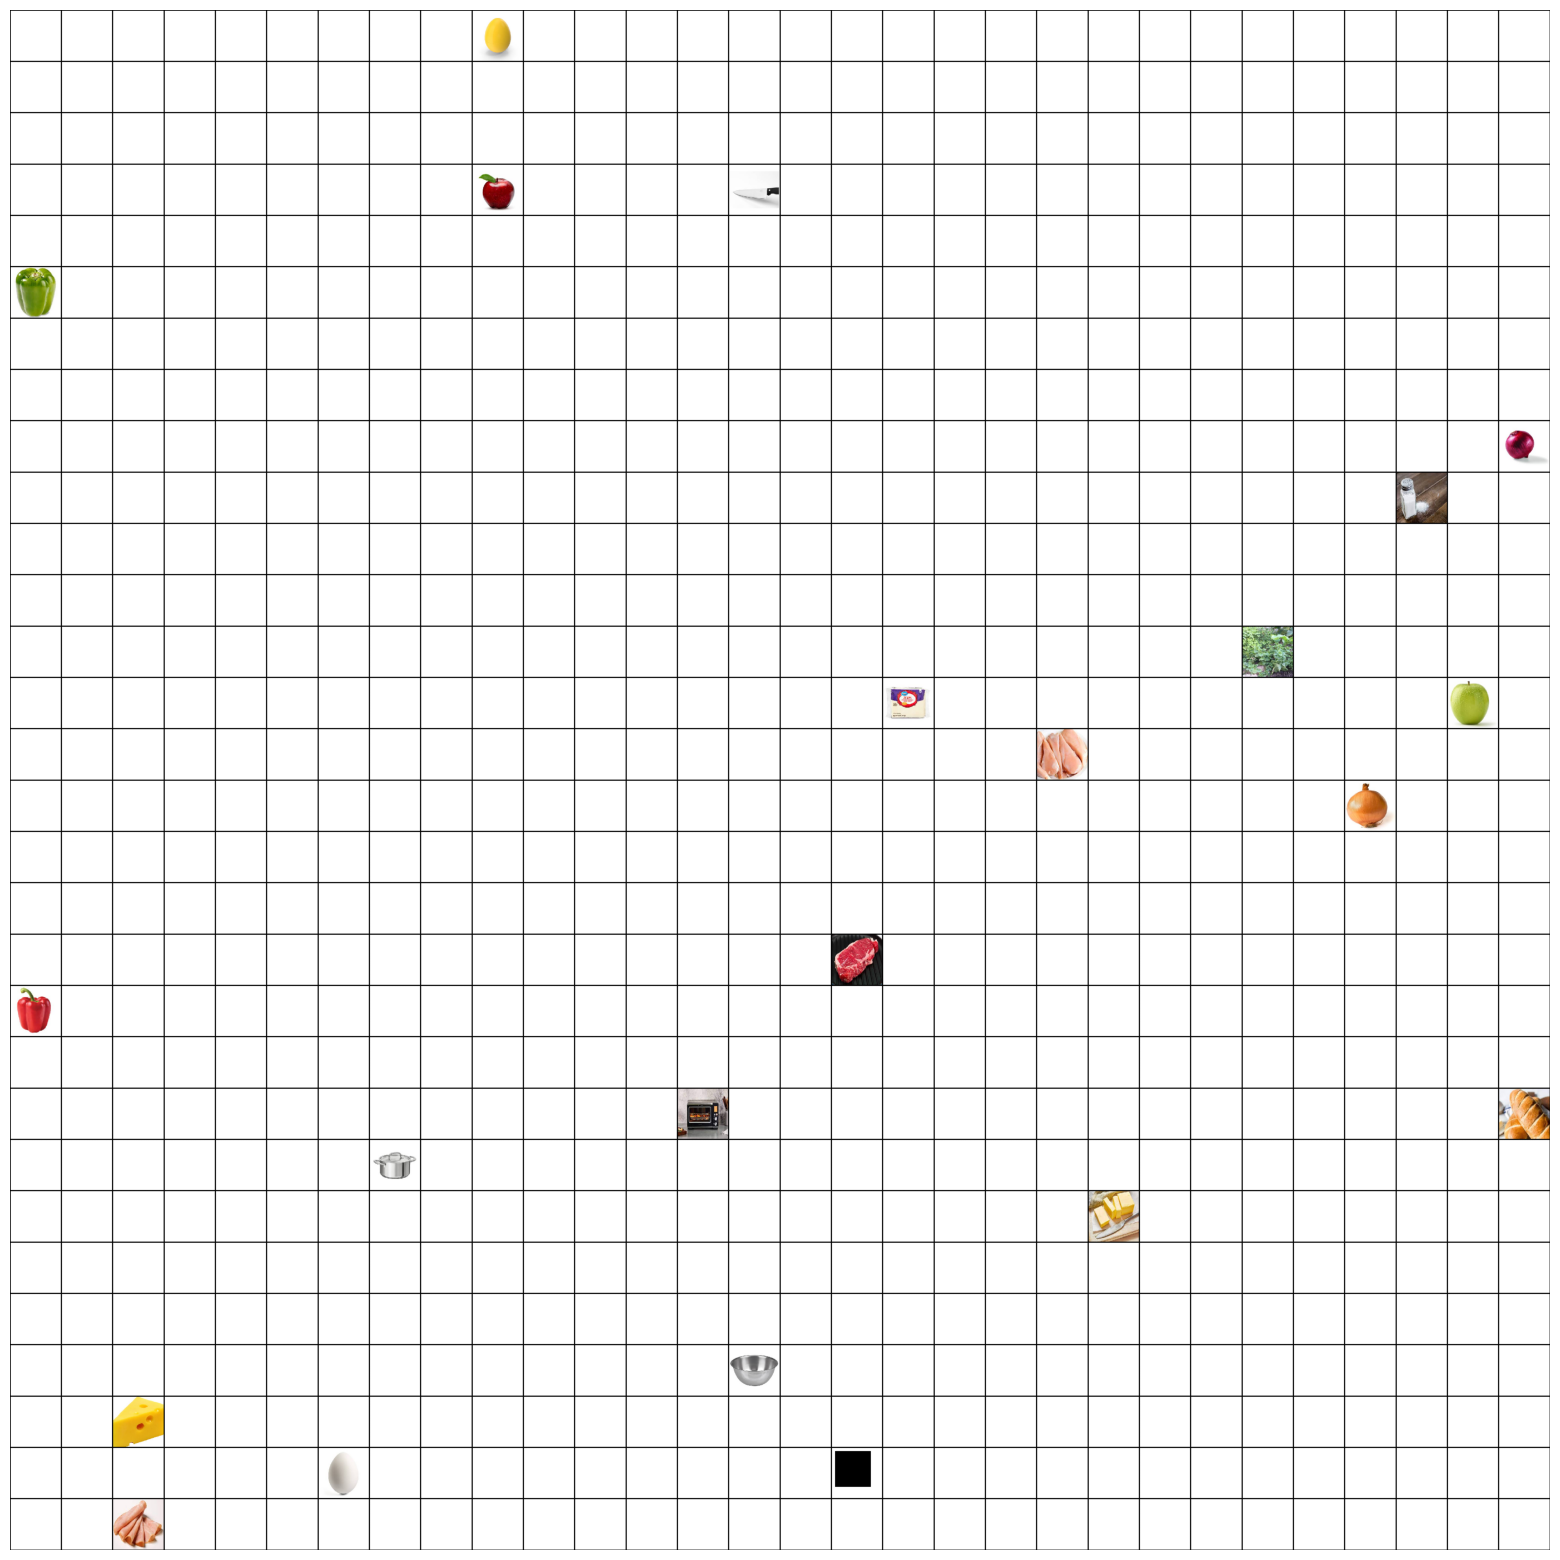

In [10]:
image_array = env._render_frame()

plt.figure(figsize=(20, 20))
# Display the image array
plt.imshow(image_array)
plt.axis('off')  # Hide the axis
plt.show()


In [66]:
print(a)
print(b)

{'distance to Red Apple': 30.0, 'distance to Red Onions': 28.0, 'distance to Yellow Onions': 39.0, 'distance to Bread': 31.0, 'distance to Yellow Cheese': 22.0, 'distance to White Cheese': 10.0, 'distance to Red Bell Pepper': 21.0, 'distance to Green Bell Pepper': 31.0, 'distance to Green Apple': 31.0, 'distance to Yellow Egg': 10.0, 'distance to White Egg': 4.0, 'distance to Butter': 38.0, 'distance to Ham': 22.0, 'distance to Red Meat (Beef)': 40.0, 'distance to White Meat (Turkey)': 22.0, 'distance to Salt': 18.0, 'distance to Herbs': 8.0, 'distance to Pot': 13.0, 'distance to Oven': 23.0, 'distance to Knife': 14.0, 'distance to Mixing Bowl': 12.0, 'distance to Plate': 18.0}
[]
